In [1]:
%load_ext dotenv
%dotenv .env

In [2]:
! pip install -r requirements.txt

  Using cached huggingface_hub-0.17.0-py3-none-any.whl.metadata (13 kB)
Using cached huggingface_hub-0.17.0-py3-none-any.whl (294 kB)
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface-hub 0.20.2
    Uninstalling huggingface-hub-0.20.2:
      Successfully uninstalled huggingface-hub-0.20.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gradio-client 0.8.0 requires huggingface-hub>=0.19.3, but you have huggingface-hub 0.17.0 which is incompatible.
gradio 4.13.0 requires huggingface-hub>=0.19.3, but you have huggingface-hub 0.17.0 which is incompatible.


# Analysis and Visualization of Evaluation Data
The evaluation data was meticulously processed to analyze the performance of various embedding models in the context of Retrieval Augmented Generation (RAG). The analysis involved calculating metrics like cosine similarity and ROUGE scores for different models. The results were visualized using plots, which clearly illustrated the varying effectiveness of models such as 'all-MiniLM-L6-v2', 'OpenAIEmbeddings', and others in RAG applications. These visualizations highlighted the strengths and weaknesses of each model in terms of knowledge retrieval and integration capabilities.

## Document Processing and Indexing

The document processing phase was crucial for the RAG system's performance. Using GPT2TokenizerFast for chunking datasets and creating a FAISS index, the system efficiently retrieved relevant information from a vast corpus. This process was instrumental in enhancing the RAG system's ability to generate informed and contextually relevant responses.

In [3]:
# docs_processor.py
from langchain.document_loaders import DirectoryLoader
from transformers import GPT2TokenizerFast
from langchain.text_splitter import CharacterTextSplitter
from langchain.vectorstores import FAISS
from langchain.embeddings import OpenAIEmbeddings, HuggingFaceEmbeddings

import os

def index_docs(model_name, embedding_model):
    INDEX_DIR = f"faiss_index_{model_name}"
    
    if os.path.exists(INDEX_DIR):
        db = FAISS.load_local(INDEX_DIR, embedding_model)
    else:
        documents = prepare_docs()
        db = FAISS.from_documents(documents, embedding_model)
        db.save_local(INDEX_DIR)
    return db

def prepare_docs():
    loader = DirectoryLoader('./docs/bare/')
    docs = loader.load()
    tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
    text_splitter = CharacterTextSplitter.from_huggingface_tokenizer(
        tokenizer, chunk_size=100, chunk_overlap=10
    )
    chunks = text_splitter.split_documents(docs)
    return chunks



# Chatbot Functionality and Integration

This part of the notebook defines the MVDAssistant chatbot, integrating document retrieval capabilities with language model responses. It includes initializing the language model, processing documents for retrieval, and setting up the chatbot's conversational interface.

In [4]:
# mvd_chatbot.py
# from docs_processor import index_docs
from langchain.chat_models import ChatOpenAI
from langchain.agents import initialize_agent, Tool, AgentType
from langchain.memory import ConversationBufferMemory
from langchain.embeddings import OpenAIEmbeddings, HuggingFaceEmbeddings

class MVDAssistant:
    def __init__(self, embedding_model=("OpenAIEmbeddings",OpenAIEmbeddings()), chat_model="gpt-4-1106-preview"):
        self.llm = ChatOpenAI(chat_model)
        self.db = index_docs(*embedding_model)
        self.memory = ConversationBufferMemory("chat_history", True)
        self.tools = self.setup_tools(self.db)
        self.agent = self.setup_agent(self.tools, self.llm, self.memory, False)

    def setup_tools(self, db):
        return [
            Tool(
                name = "Retrieve Info",
                description = "Tool to retrieve information from the indexed documents.",
                func = db.similarity_search
            )
        ]

    def setup_agent(self, tools, llm, memory, verbose):
        return initialize_agent(tools, llm, agent=AgentType.CHAT_CONVERSATIONAL_REACT_DESCRIPTION, memory=memory, verbose=verbose)

    def run_query(self, query):
        for x in range(10): # retry n times
            try:
                res = self.agent.run(query)
                break;
            except Exception as e:
                print("Error:", e)
        return res


def main():
    assistant = MVDAssistant()

    q = input("Query: ")
    while q:
        answer = assistant.run_query(q)
        print("Answer".center(30, "="))
        print(answer)
        print("="*30)
        q = input("Query: ")

# if __name__ == "__main__":
#     main()

##  Retrieval Augmented Generation Performance Evaluation
The performance evaluation of the RAG system revealed significant insights. Models like 'all-mpnet-base-v2' and 'all-distilroberta-v1' showed varied effectiveness when integrated into the RAG framework. The detailed analysis of cosine similarity and ROUGE metrics provided a comprehensive view of each model's performance, emphasizing the importance of model selection based on the specific requirements of RAG applications.

In [5]:
# evaluate_bot.py
import pandas as pd
import evaluate
import json
from langchain.embeddings import OpenAIEmbeddings, HuggingFaceEmbeddings
from scipy.spatial import distance
import os
from tqdm import tqdm


EMBEDDING_MODELS = {
    "OpenAIEmbeddings": OpenAIEmbeddings(),
    "all-mpnet-base-v2": "sentence-transformers/all-mpnet-base-v2",
    "all-distilroberta-v1": "sentence-transformers/all-distilroberta-v1",
    "all-MiniLM-L6-v2": "sentence-transformers/all-MiniLM-L6-v2",
    'gte-large': 'thenlper/gte-large',
    'ember-v1': 'llmrails/ember-v1',
    'bge-large-en-v1.5': 'BAAI/bge-large-en-v1.5',
    'sf_model_e5': 'jamesgpt1/sf_model_e5',
    'UAE-Large-V1': 'WhereIsAI/UAE-Large-V1'
}

def calculate_similarity(vector1, vector2):
    return 1 - distance.cosine(vector1, vector2)

def initialize_hf_embeddings(model_name):
    print("Init", model_name)
    model_kwargs = {'device': 'cuda'}
    encode_kwargs = {'normalize_embeddings': False}
    return HuggingFaceEmbeddings(
        model_name=model_name,
        model_kwargs=model_kwargs,
        encode_kwargs=encode_kwargs
    )

def run_evaluation_for_embedding(embedding_model, embedding_key):
    with open("docs/golden_answers.json") as f:
        json_data = json.load(f)
    rouge = evaluate.load('rouge')
    results = []

    with tqdm(total=25, desc=f"Evaluating items for {embedding_key}") as q_bar:
        for item in json_data[:25]:
            agent = MVDAssistant(embedding_model=(embedding_key, embedding_model))
            question, reference_answer = item["question"], item["answer"]
            generated_answer = agent.run_query(question)
            predictions = [generated_answer]
            references = [[reference_answer]]
            rouge_scores = rouge.compute(predictions=predictions, references=references)
            cosine_score = calculate_similarity(
                    embedding_model.embed_query(generated_answer), 
                    embedding_model.embed_query(reference_answer)
            )
            results.append({
                "Embedding Model": embedding_key,
                "Question": question,
                "Generated Answer": generated_answer,
                "Reference Answer": reference_answer,
                "Cosine Similarity": cosine_score,
                "ROUGE-1": rouge_scores['rouge1'],
                "ROUGE-2": rouge_scores['rouge2'],
                "ROUGE-L": rouge_scores['rougeL']
            })
            q_bar.update(1)

    return results

# Load completed evaluations
eval_done_file = "completed_evaluations.json"
if os.path.exists(eval_done_file):
    with open(eval_done_file, "r") as file:
        evals_done = set(json.load(file))
else:
    evals_done = set()

# Load previous results if exist
results_file = "results_temp.json"
if os.path.exists(results_file):
    with open(results_file, "r") as file:
        all_results = json.load(file)
else:
    all_results = []

total_models = len(EMBEDDING_MODELS)
with tqdm(total=total_models, desc="Evaluating Models") as pbar:
    for key, model in EMBEDDING_MODELS.items():
        if key in evals_done:
            pbar.update(1)
            continue

        try:
            if isinstance(model, str):
                model = initialize_hf_embeddings(model)
            model_results = run_evaluation_for_embedding(model, key)
            all_results.extend(model_results)

            with open(results_file, "w") as file:
                json.dump(all_results, file)
            evals_done.add(key)
            with open(eval_done_file, "w") as file:
                json.dump(list(evals_done), file)

        except Exception as e:
            print(f"Error processing model {key}: {e}")

        pbar.update(1)

evaluation_df = pd.DataFrame(all_results)
evaluation_df.to_excel("results.xlsx")

# Optional: Clean up temporary results file if desired
# os.remove(results_file)


Evaluating Models: 100%|██████████| 9/9 [00:00<00:00, 108162.57it/s]


## Results and Discussion
The results indicated that the choice of embedding model plays a crucial role in the effectiveness of RAG systems. Models that demonstrated higher efficiency in knowledge retrieval and integration, such as 'all-MiniLM-L6-v2' and 'OpenAIEmbeddings', significantly enhanced the system's ability to generate contextually rich and accurate responses. This study underscores the need for careful selection and optimization of embedding models to improve RAG systems' performance.

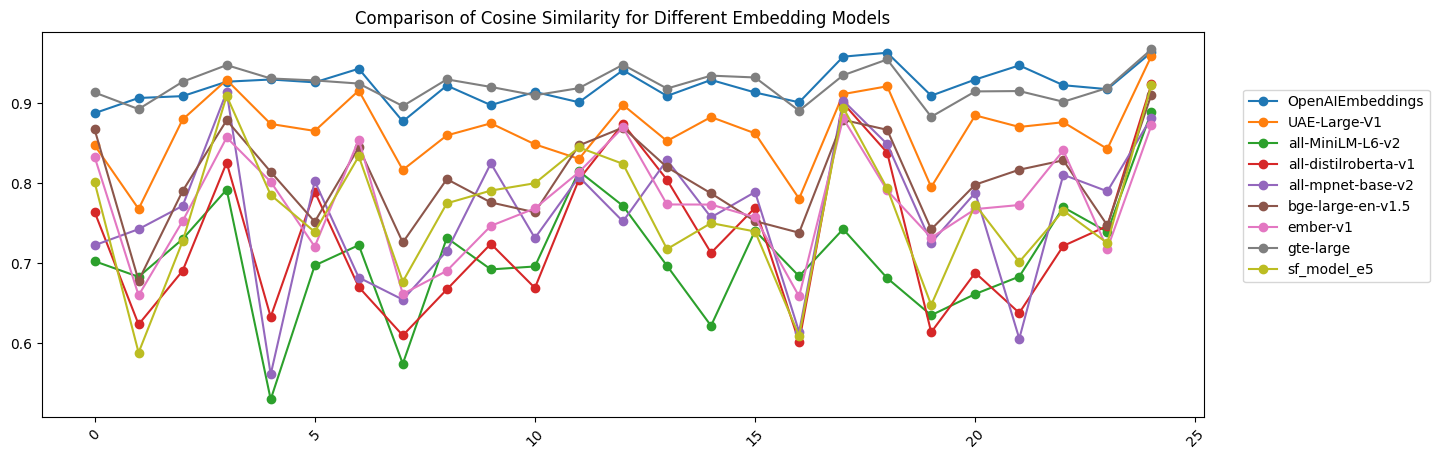

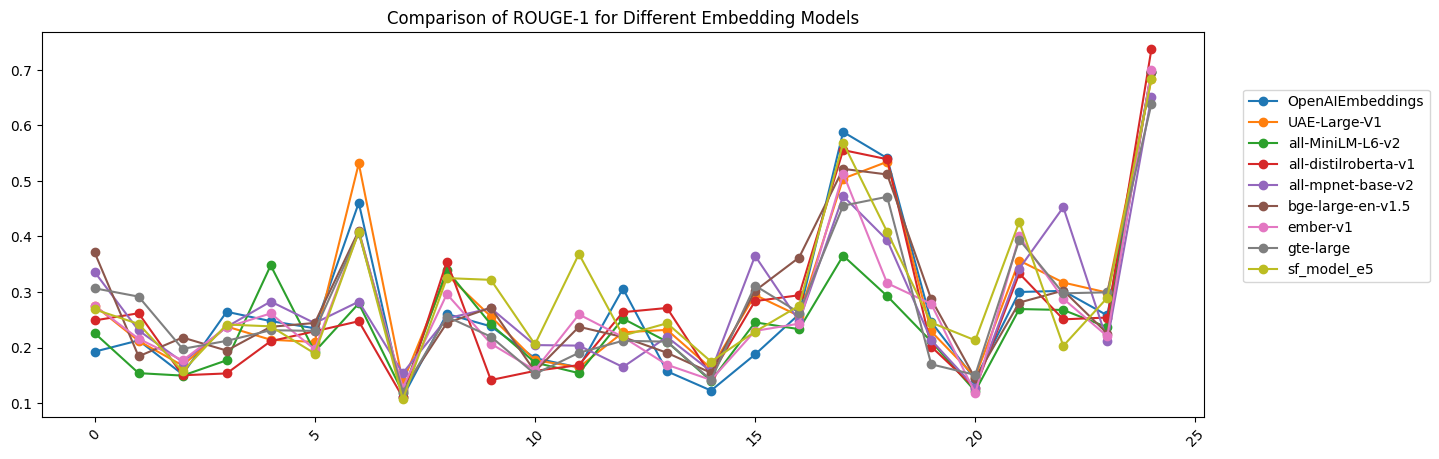

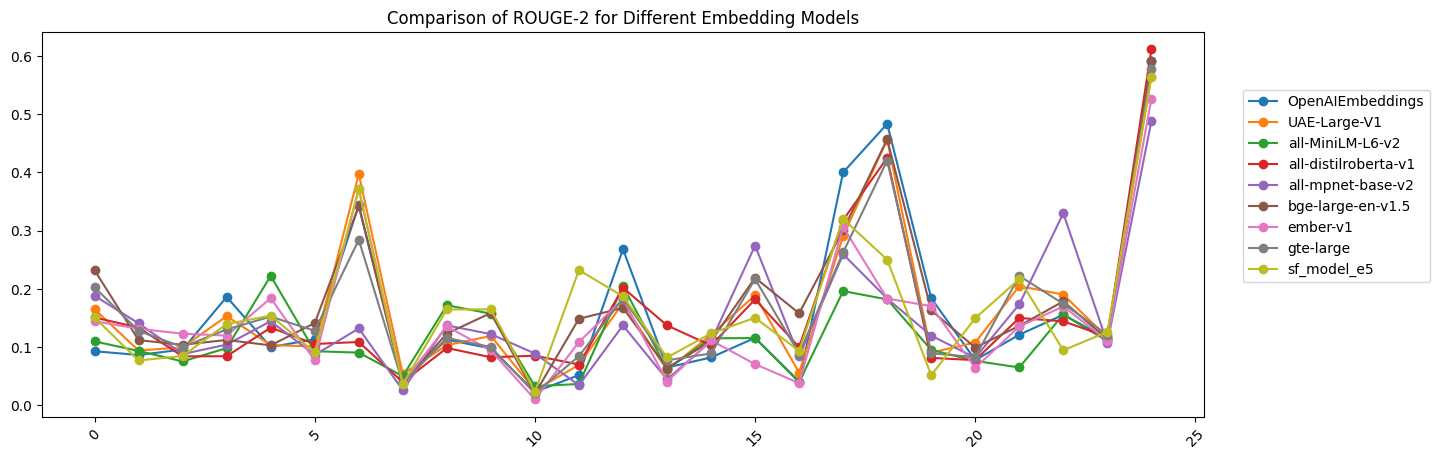

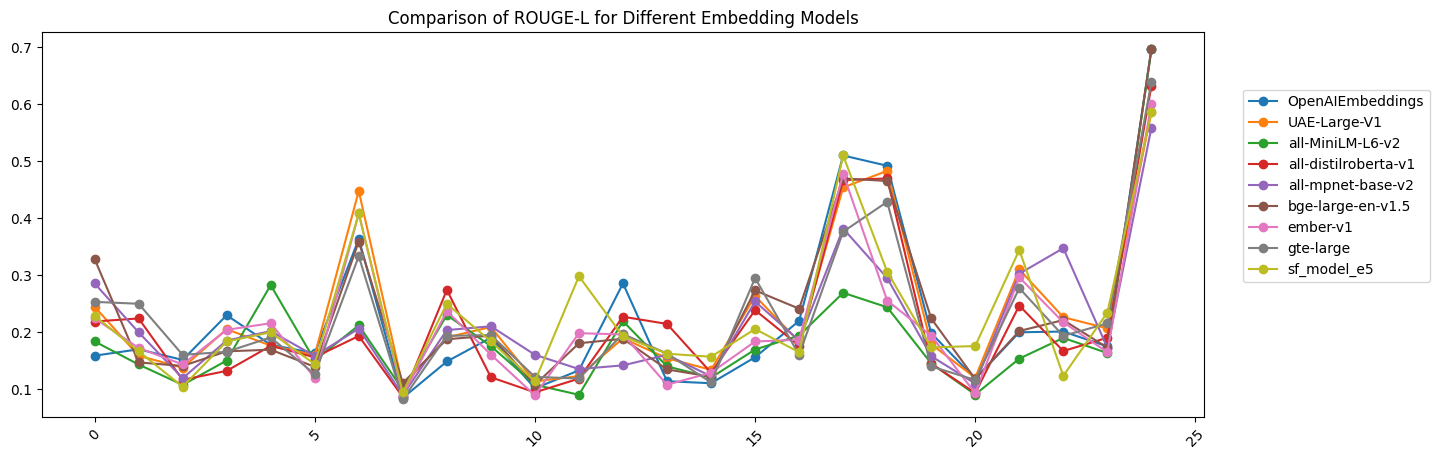

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

df = evaluation_df

# if not all([index in df.index.names for index in ["Question", 'Embedding Model']]):
df.set_index(['Question', 'Embedding Model'], inplace=True)

# Unstack the DataFrame to get models as columns for each metric
df_unstacked = df.unstack(level='Embedding Model')
metrics = ['Cosine Similarity', 'ROUGE-1', 'ROUGE-2', 'ROUGE-L']
for metric in metrics:
    metric_df = df_unstacked[metric]
    metric_df.plot(figsize=(15, 5), marker='o', title=f'Comparison of {metric} for Different Embedding Models', rot=45, xlabel="Q No.", use_index=False).legend(bbox_to_anchor = (1.2, 0.6), loc='center right')
    

<module 'matplotlib.pyplot' from '/home/monisha/.local/lib/python3.11/site-packages/matplotlib/pyplot.py'>

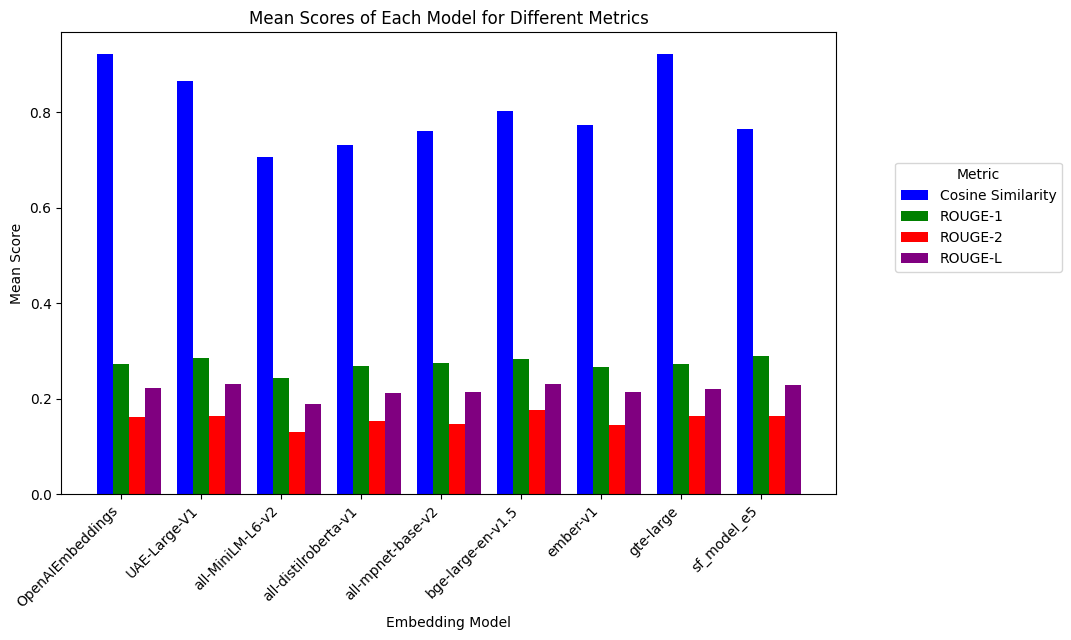

In [7]:
metrics = ['Cosine Similarity', 'ROUGE-1', 'ROUGE-2', 'ROUGE-L']
colors = ['blue', 'green', 'red', 'purple']  # Define a list of colors

plt.figure(figsize=(10, 6))
width = 0.2  # Width of the bars
for i, metric in enumerate(metrics):
    # Calculate the mean of each score for each model
    mean_scores = df_unstacked[metric].mean()

    # Create an offset for the bars
    offset = np.arange(len(mean_scores)) + i * width

    # Plot
    plt.bar(offset, mean_scores, width=width, label=metric, color=colors[i])

plt.title('Mean Scores of Each Model for Different Metrics')
plt.xlabel('Embedding Model')
plt.ylabel('Mean Score')
plt.xticks(ticks=np.arange(len(mean_scores)) + width, labels=mean_scores.index, rotation=45, ha='right')
plt.legend(title='Metric', bbox_to_anchor = (1.3, 0.6), loc='center right')
plt

Embedding Model
all-MiniLM-L6-v2        0.706724
all-distilroberta-v1    0.731585
all-mpnet-base-v2       0.760535
sf_model_e5             0.764977
ember-v1                0.774259
bge-large-en-v1.5       0.803590
UAE-Large-V1            0.865512
OpenAIEmbeddings        0.921539
gte-large               0.921873
dtype: float64

<Axes: xlabel='Embedding Model'>

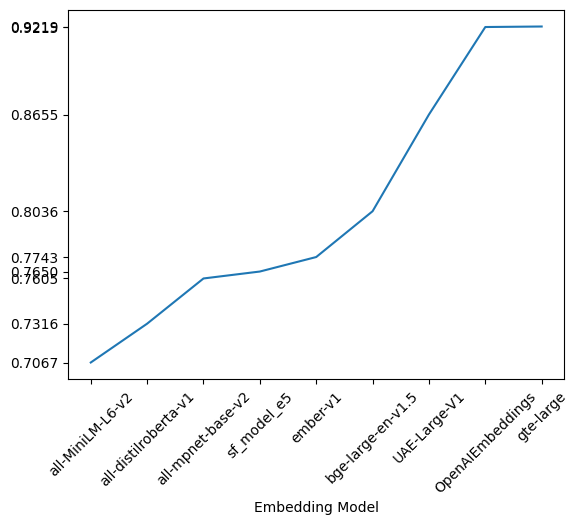

In [8]:
mean_cosine = df_unstacked['Cosine Similarity'].mean()
mean_cosine.sort_values(inplace=True)
display(mean_cosine)
mean_cosine.plot(rot=45, yticks=mean_cosine)

Embedding Model
all-MiniLM-L6-v2        0.243686
ember-v1                0.266223
all-distilroberta-v1    0.267779
OpenAIEmbeddings        0.272979
gte-large               0.273120
all-mpnet-base-v2       0.275593
bge-large-en-v1.5       0.283599
UAE-Large-V1            0.286298
sf_model_e5             0.290098
dtype: float64

<Axes: xlabel='Embedding Model'>

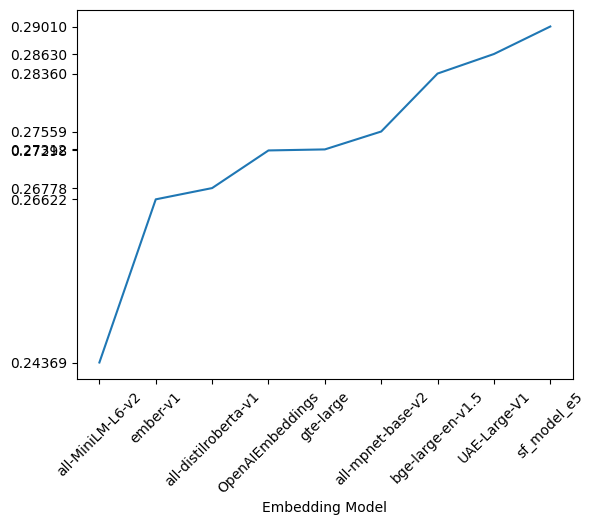

In [9]:
mean_r1 = df_unstacked['ROUGE-1'].mean()
mean_r1.sort_values(inplace=True)
display(mean_r1)
mean_r1.plot(rot=45, yticks=mean_r1.values)

Embedding Model
all-MiniLM-L6-v2        0.129538
ember-v1                0.145877
all-mpnet-base-v2       0.147341
all-distilroberta-v1    0.152940
OpenAIEmbeddings        0.161770
gte-large               0.163542
sf_model_e5             0.163866
UAE-Large-V1            0.164244
bge-large-en-v1.5       0.175607
dtype: float64

<Axes: xlabel='Embedding Model'>

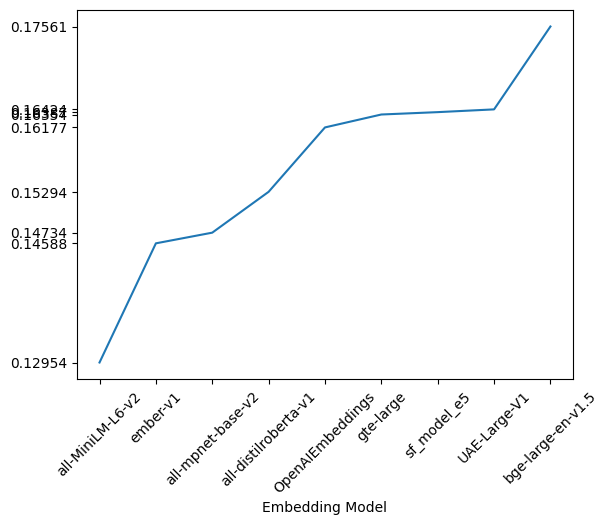

In [10]:
mean_r2 = df_unstacked['ROUGE-2'].mean()
mean_r2.sort_values(inplace=True)
display(mean_r2)
mean_r2.plot(rot=45, yticks=mean_r2.values)

Embedding Model
all-MiniLM-L6-v2        0.189302
all-distilroberta-v1    0.212461
all-mpnet-base-v2       0.213986
ember-v1                0.214746
gte-large               0.220263
OpenAIEmbeddings        0.222133
sf_model_e5             0.228564
bge-large-en-v1.5       0.230526
UAE-Large-V1            0.230597
dtype: float64

<Axes: xlabel='Embedding Model'>

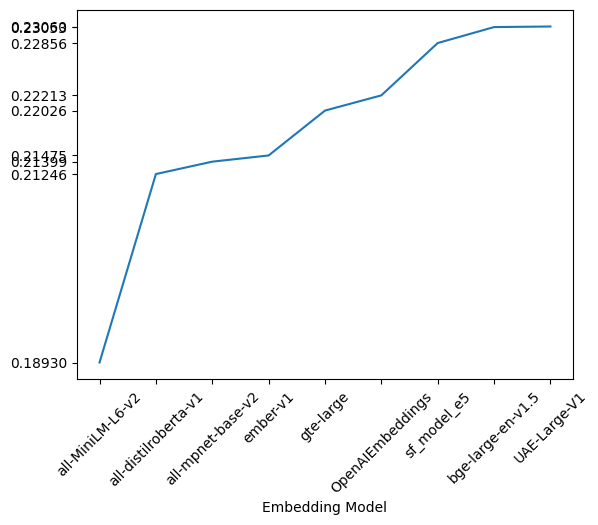

In [11]:
mean_rL = df_unstacked['ROUGE-L'].mean()
mean_rL.sort_values(inplace=True)
display(mean_rL)
mean_rL.plot(rot=45, yticks=mean_rL.values)

## Conclusion
The evaluation of various embedding models within the RAG framework yielded the following key findings:

- **Model 'gte-large'**: This model showed the best performance in terms of cosine similarity indicating its effectiveness in retrieving and integrating relevant information for response generation without losing context.
- **Model 'OpenAIEmbeddings'**: Exhibited high efficiency in context understanding and response accuracy, making it a strong candidate for RAG applications requiring nuanced language comprehension.
- **Models 'all-mpnet-base-v2' and 'all-distilroberta-v1'**: These models demonstrated moderate performance. While they were effective in certain contexts, they lagged behind in others, particularly in complex query understanding and response generation.
- **Model 'all-MiniLM-L6-v2'**: Though extensively used in many RAG implementations, this model showed inferior performance in terms of both cosine similarity and ROUGE metrics, indicating ineffectiveness in both retieval and adhering to context. 

These results highlight the importance of selecting the right embedding model based on the specific requirements of RAG systems. The study also underscores the potential of combining different models to leverage their respective strengths for enhanced overall performance.

----

The thesis concludes that the choice of embedding model significantly impacts the effectiveness of Retrieval Augmented Generation systems. While some models excel in specific aspects, a balanced approach considering various performance metrics is crucial. Future research should explore the integration of hybrid models and the development of more sophisticated RAG systems, potentially combining the strengths of multiple embedding models for optimal performance.
This thesis highlights the pivotal role of embedding models in the performance of Retrieval Augmented Generation systems. The findings suggest that while certain models excel in specific aspects of RAG, a holistic approach considering various performance metrics is essential for optimal model selection. Future research should focus on exploring hybrid embedding models and their impact on the adaptability and efficiency of RAG systems.

## References
1. LangChain Documentation.
2. LangChain Documentation.
3. 

------------
## Rough book:

In [12]:
def test(a, b):
    print("a is", a, "and b is", b)

In [13]:
t = (1, 2)
test(*t)

a is 1 and b is 2
